In [224]:
import numpy as np
import importlib
import matplotlib as mpl
import matplotlib.pylab as plt
import time
from copy import deepcopy
import torch
import IPython.display as IPd
import pandas as pd
import dill as pickle

from stg_energy.common import col, svg, samples_nd, get_labels_8pt
# from stg_energy.fig5_cc.viz import vis_sample_plain
from pyloric import simulate, summary_stats, create_prior
from stg_energy.fig6_temp.process_samples import merge_samples
import stg_energy.fig6_temp.viz as viz
from sbi.analysis import ActiveSubspace

from stg_energy import check_if_close_to_obs

import pyabf

# Fig 7: posterior over temperatures

In [225]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [353]:
PANEL_exp1 = '../svg/panel_exp1.svg'
PANEL_exp2 = '../svg/panel_exp2.svg'

PANEL_exp1_spikes = '../svg/panel_exp1_spikes.svg'
PANEL_exp2_spikes = '../svg/panel_exp2_spikes.svg'

PANEL_A1 = '../svg/panel_a1_ink.svg'
PANEL_A2 = '../svg/panel_a2_ink.svg'

PANEL_B1 = '../svg/panel_b1.svg'
PANEL_B2 = '../svg/panel_b2.svg'

PANEL_C1 = '../svg/panel_c1.svg'
PANEL_C2 = '../svg/panel_c2.svg'
PANEL_C3 = '../svg/panel_c3.svg'

PANEL_D1 = '../svg/panel_d1.svg'
PANEL_D2 = '../svg/panel_d2.svg'

PANEL_E1 = '../svg/panel_e1.svg'
PANEL_E2 = '../svg/panel_e2.svg'
PANEL_E3 = '../svg/panel_e3.svg'
PANEL_E4 = '../svg/panel_e4.svg'

PANEL_F = '../svg/panel_f.svg'
PANEL_G = '../svg/panel_g.svg'

PANEL_F_supp1 = '../svg/panel_f_supp1.svg'
PANEL_F_supp2 = '../svg/panel_f_supp2.svg'

In [227]:
prior_11 = create_prior(as_torch_dist=True)
prior_27 = create_prior(
    customization={
        "Q10_gbar_mem": [True, True, True, True, True, True, True, True],
        "Q10_gbar_syn": [True, True],
        "Q10_tau_m": [False],
        "Q10_tau_h": [False],
        "Q10_tau_CaBuff": [False],
        "Q10_tau_syn": [False, False],
    },
    as_torch_dist=True
)
prior_27_lower = prior_27.support.base_constraint.lower_bound
prior_27_upper = prior_27.support.base_constraint.upper_bound
lims_27 = np.asarray([prior_27_lower.numpy(), prior_27_upper.numpy()]).T

### Load samples from 11 deg, 15deg, 19deg, 23deg, 27deg

In [228]:
xo11 = np.load("../../../results/experimental_data/xo_11deg.npy")
xo27 = np.load("../../../results/experimental_data/xo_27deg.npy")

npz = np.load("../../../results/experimental_data/trace_data_845_082_0044.npz")
t = npz["t"]

In [229]:
sims_p = "../../../results/simulation_data_Tube_MLslurm_cluster/"

In [230]:
theta_11_11_close = pd.read_pickle(sims_p+"close_to_xo_circuit_parameters.pkl")
x_11_11_close = pd.read_pickle(sims_p+"close_to_xo_simulation_outputs.pkl")
seeds_11_11_close = np.load(sims_p+"close_to_xo_seeds.npy")

theta_11_11_close_np = theta_11_11_close.to_numpy()
x_11_11_close_np = x_11_11_close.to_numpy()

In [231]:
theta_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/all_circuit_parameters.pkl")
x_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/all_simulation_outputs.pkl")
seeds_27_11 = np.load(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/all_seeds.npy")

theta_27_11_np = theta_27_11.to_numpy()
x_27_11_np = x_27_11.to_numpy()

In [232]:
theta_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/all_circuit_parameters.pkl")
x_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/all_simulation_outputs.pkl")
seeds_27_27 = np.load(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/all_seeds.npy")

theta_27_27_np = theta_27_27.to_numpy()
x_27_27_np = x_27_27.to_numpy()

In [233]:
condition_rejection_nan = pd.read_pickle(sims_p+"simulate_11deg_R3_predictives_at_27deg_notau_only_close/data/simulation_outputs/sim_0.pkl")
condition_rejection_nan_np = condition_rejection_nan.to_numpy()

condition_rejection = np.invert(np.any(np.isnan(condition_rejection_nan_np), axis=1))

x_11_11_rejection_nan = x_11_11_close[condition_rejection]
x_11_11_rejection_nan = x_11_11_rejection_nan.loc[x_11_11_rejection_nan['pyloric_like']['Circuit'] == 1.0]
x_11_11_rejection_nan_np = x_11_11_close_np[condition_rejection]

In [234]:
x_11_11_rejection_nan_np.shape

(11983, 34)

In [235]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [236]:
with open("../../../results/trained_neural_nets/inference/posterior_27deg_notau_082.pickle", "rb") as handle:
    posterior = pickle.load(handle)
posterior._sample_with = "rejection"

/home/michael/Documents/sbi/sbi/inference/posteriors/base_posterior.py:1130: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False` `self._sample_with = rejection`
  warn(warning_description + warning_msg)


### Check if theta at 11 and 27 predictives are indeed the same

In [237]:
test_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/circuit_parameters/sim_0.pkl")
test_27_11_np = test_27_11.to_numpy()

In [238]:
test_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/circuit_parameters/sim_0.pkl")
test_27_27_np = test_27_27.to_numpy()

### Select only those stats that were sufficiently close at 11 and 27 degree

In [239]:
close_at_11 = check_if_close_to_obs(x_27_11_np)

In [240]:
close_at_27 = check_if_close_to_obs(x_27_27_np, xo=xo27[:15])

In [241]:
close_at_both = np.asarray([c1 and c2 for c1, c2 in zip(close_at_11, close_at_27)])

In [242]:
x_27_27_close = x_27_27[close_at_both]
theta_27_27_close = theta_27_27[close_at_both]
seeds_27_27_close = seeds_27_27[close_at_both]

x_27_27_close_np = x_27_27_np[close_at_both]
theta_27_27_close_np = theta_27_27_np[close_at_both]

In [243]:
x_27_11_close = x_27_11[close_at_both]
theta_27_11_close = theta_27_11[close_at_both]
seeds_27_11_close = seeds_27_11[close_at_both]

x_27_11_close_np = x_27_11_np[close_at_both]
theta_27_11_close_np = theta_27_11_np[close_at_both]

In [244]:
np.sum(close_at_both)

6131

### Reset indizes to start at 1

In [245]:
x_27_11_close.index = np.arange(len(x_27_11_close))
theta_27_11_close.index = np.arange(len(theta_27_11_close))

x_27_27_close.index = np.arange(len(x_27_27_close))
theta_27_27_close.index = np.arange(len(theta_27_27_close))

# Plot experimental data

In [286]:
npz = np.load('../../../results/experimental_data/trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']

In [287]:
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

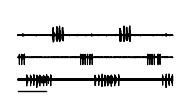

In [288]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.1)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 2.5+pdn[start_index:end_index]*0.007, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 1.2+lpn[start_index:end_index]*0.25, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], -0.1+pyn[start_index:end_index]*0.013, c="k", lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    ax.set_ylim([-0.95, 4.0])
    
    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, -0.8 * np.ones_like(t_scale), c='k', lw=1.0)
    
    plt.savefig(PANEL_exp1, facecolor='None', transparent=True)
    plt.show()

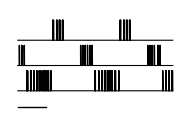

In [289]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 2.5+PD_spikes[start_index:end_index], c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 1.25+LP_spikes[start_index:end_index], c="k", lw=0.8)
    ax.plot(t[start_index:end_index], PY_spikes[start_index:end_index], c="k", lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    ax.set_ylim([-0.95, 4.0])
    
    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)
    
    ax.plot(t_scale, -0.8 * np.ones_like(t_scale), c='k', lw=1.0)
    
    plt.savefig(PANEL_exp1_spikes, facecolor='None', transparent=True)
    plt.show()

In [290]:
name = '845_082_0064'
datafile = "../../../results/experimental_data/"+name+".abf"
abf = pyabf.ABF(datafile)

In [291]:
channel_names = abf.adcNames
channel_data = abf.data

In [292]:
LPN = channel_data[3]
PYN = channel_data[1]
PDN = channel_data[2]
LVN = channel_data[6]
sampling_frequency = abf.dataRate

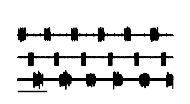

In [293]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.1)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 2.5+PDN[start_index:end_index]*0.007, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 1.2+LPN[start_index:end_index]*0.25, c="k", lw=0.8)
    ax.plot(t[start_index:end_index], -0.1+PYN[start_index:end_index]*0.013, c="k", lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    ax.set_ylim([-0.95, 4.0])

    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)

    ax.plot(t_scale, -0.8 * np.ones_like(t_scale), c='k', lw=1.0)

    plt.savefig(PANEL_exp2, facecolor='None', transparent=True)
    plt.show()

In [294]:
npz = np.load('../../../results/experimental_data/data_845_082_0064.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']

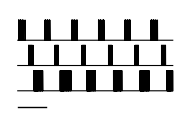

In [295]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1,figsize=(2.2, 1.3)) # (2.87, 2.08*3/4)
    ax.plot(t[start_index:end_index], 2.5+PD_spikes[start_index:end_index], c="k", lw=0.8)
    ax.plot(t[start_index:end_index], 1.25+LP_spikes[start_index:end_index], c="k", lw=0.8)
    ax.plot(t[start_index:end_index], PY_spikes[start_index:end_index], c="k", lw=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    ax.get_yaxis().set_visible(False)
    ax.set_ylim([-0.95, 4.0])

    duration = 0.5
    number_of_timesteps = int(duration / dt)
    t_scale = np.linspace(t[start_index], t[start_index + number_of_timesteps], 2)

    ax.plot(t_scale, -0.8 * np.ones_like(t_scale), c='k', lw=1.0)

    plt.savefig(PANEL_exp2_spikes, facecolor='None', transparent=True)
    plt.show()

# Plot posteriors

In [338]:
labels_ = get_labels_8pt()
labels_[9] += ''

/home/michael/Documents/STG_energy/stg_energy/common.py:770: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


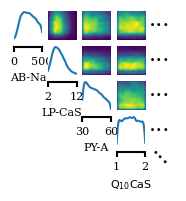

In [339]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    q10_samples = prior_27.sample((theta_11_11_close_np.shape[0],)).numpy()[:, -10:]
    sample_params_11_q10 = np.concatenate((theta_11_11_close_np, q10_samples), axis=1)
    _ = samples_nd(
        samples=sample_params_11_q10[:10000],
        subset=[0,10,19,33],
        upper=['kde'],
        diag=['kde'],
        fig_size=(1.7, 1.7),
        limits=lims_27,
        ticks=lims_27,
        labels=labels_,
    )
    plt.savefig(PANEL_A1, facecolor='None', transparent=True)

/home/michael/Documents/STG_energy/stg_energy/common.py:770: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


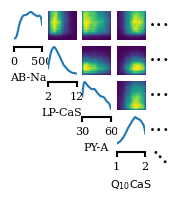

In [340]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    sample_params_27_norm = theta_27_27_np
    _ = samples_nd(
        samples=sample_params_27_norm[:10000],
        subset=[0,10,19,33],
        upper=['kde'],
        diag=['kde'],
        fig_size=(1.7, 1.7),
        limits=lims_27,
        ticks=lims_27,
        labels=labels_,
    )
    plt.savefig(PANEL_A2, facecolor='None', transparent=True)

# Plot a sample from the 27deg posterior across temperatures

In [355]:
time_vec = np.arange(0, 11000, 0.025)

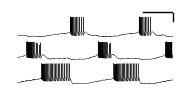

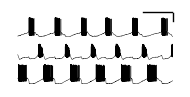

In [379]:
sample_index = 3
counter = 0
offsets = [82000, 16500]

for temp in [283, 299]:

    out_target = simulate(
        theta_27_27_close.loc[sample_index],
        seed=int(seeds_27_27_close[sample_index]),
        temperature=temp,
    )

    with mpl.rc_context(fname="../../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 1, facecolor="white", figsize=(2.2, 1.0))
        fig = viz.vis_sample_plain(
            out_target,
            time_vec,
            ax,
            time_len=int(shown_t / 0.025 * 1000),
            col='k',
            offset=offsets[counter],
            scale_bar=True,
        )
        if temp == 283:
            plt.savefig(PANEL_B1, facecolor='None', transparent=True)
        elif temp == 299:
            plt.savefig(PANEL_B2, facecolor='None', transparent=True)
        plt.show()
        counter += 1

Pearson correlation coefficient between energy consumption at 11 and 27 degree:  0.5717866148082889


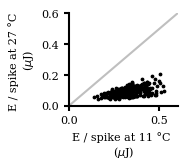

In [261]:
e_11 = np.sum(x_27_11_close['energies_per_spike'].to_numpy() * x_27_11_close['num_spikes'].to_numpy(), axis=1) / np.sum(x_27_11_close['num_spikes'].to_numpy(), axis=1) / 1000
e_27 = np.sum(x_27_27_close['energies_per_spike'].to_numpy() * x_27_27_close['num_spikes'].to_numpy(), axis=1) / np.sum(x_27_27_close['num_spikes'].to_numpy(), axis=1) / 1000

print("Pearson correlation coefficient between energy consumption at 11 and 27 degree: ", np.corrcoef(e_11, e_27)[0, 1])
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.2))
    ax.scatter(e_11[500:800], e_27[500:800], s=3, c='k')
    ax.plot([0, 0.6], [0, 0.6], c='gray', alpha=0.5)
    ax.set_xlabel("E / spike at 11 °C \n($\mu$J)")
    ax.set_ylabel("E / spike at 27 °C \n($\mu$J)")
    ax.set_xlim([0, 0.6])
    ax.set_ylim([0, 0.6])
    plt.savefig(PANEL_F_supp1, facecolor='None', transparent=True)

Pearson correlation coefficient between energy consumption at 11 and 27 degree:  0.491051573652607


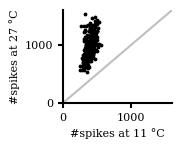

In [262]:
e_11 = np.sum(x_27_11_close['num_spikes'].to_numpy(), axis=1)
e_27 = np.sum(x_27_27_close['num_spikes'].to_numpy(), axis=1)
print("Pearson correlation coefficient between energy consumption at 11 and 27 degree: ", np.corrcoef(e_11, e_27)[0, 1])
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.4, 1.2))
    ax.scatter(e_11[500:800], e_27[500:800], s=3, c='k')
    ax.plot([0, 1600], [0, 1600], c='gray', alpha=0.5)
    ax.set_xlabel("#spikes at 11 °C")
    ax.set_ylabel("#spikes at 27 °C")
    ax.set_xlim([0, 1600])
    ax.set_ylim([0, 1600])
    plt.savefig(PANEL_F_supp2, facecolor='None', transparent=True)

In [263]:
e_11 = np.sum(x_27_11_close['energies'].to_numpy(), axis=1) / 10 / 1000
e_27 = np.sum(x_27_27_close['energies'].to_numpy(), axis=1) / 10 / 1000

In [264]:
print("Pearson correlation coefficient between energy consumption at 11 and 27 degree: ", np.corrcoef(e_11, e_27)[0, 1])

Pearson correlation coefficient between energy consumption at 11 and 27 degree:  0.6305378864155534


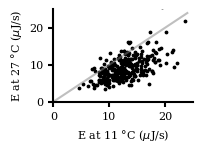

In [265]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.2))
    ax.scatter(e_11[500:800], e_27[500:800], s=3, c='k')
    ax.plot([0, 24], [0, 24], c='gray', alpha=0.5)
    ax.set_xlabel("E at 11 °C ($\mu$J/s)")
    ax.set_ylabel("E at 27 °C ($\mu$J/s)")
#     ax.arrow(6.6, 18, 0.98, -3.5, head_width=1.3, head_length=1.3, facecolor="#d7301f", edgecolor='#d7301f')
    ax.set_xlim([0, 25])
    ax.set_ylim([0, 25])
    plt.savefig(PANEL_F, facecolor='None', transparent=True)

In [266]:
# _ = torch.manual_seed(0)
# sensitivity = ActiveSubspace(posterior.set_default_x(xo27))

# theta_27_27_train = torch.as_tensor(theta_27_27_close_np[40:], dtype=torch.float32)
# energies_train = torch.as_tensor(np.sum(x_27_27_close['energies'].to_numpy()[40:], axis=1), dtype=torch.float32).unsqueeze(1)

# converged_nn = sensitivity.add_property(
#     theta_27_27_train,
#     energies_train, 
#     hidden_features=20, 
#     num_blocks=1).train()

# e_vals, e_vecs = sensitivity.find_directions()


In [267]:
# from stg_energy.fig3_active_subspaces.viz import plot_eigenvalues

# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     plot_eigenvalues(torch.log(torch.abs(torch.flip(e_vals, dims=(0,)))), figsize=(2.0, 1.0), color='k')
#     plt.show()

In [268]:
# with mpl.rc_context(fname="../../../.matplotlibrc"):
#     viz.py_sensitivity_bars_q10(
#         e_vecs[:, -1].T,
#         ylim=[-1, 1.0],
#         figsize=(2.5, 1.2),
#         ylabel="Active dir.",
#         plot_labels=True,
#         title='',
#     )
#     plt.savefig(PANEL_G, facecolor='None', transparent=True)

### Linear regression

In [269]:
from sklearn.linear_model import LinearRegression

In [270]:
num_test = 500

test_params = theta_27_27_close_np[:num_test]
train_params = theta_27_27_close_np[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [271]:
summed_energy = np.sum(x_27_27_close['energies'].to_numpy(), axis=1)
numSpikesPerBurst = torch.as_tensor(summed_energy)

train_energy_ABPD = numSpikesPerBurst[num_test:].unsqueeze(1)
test_energy_ABPD = numSpikesPerBurst[:num_test].unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

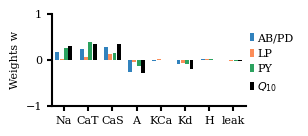

In [272]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_q10(
        deepcopy(coeff[0]),
        ylim=[-1, 1.0],
        figsize=(2.5, 1.2),
        ylabel="Weights w",
        plot_labels=True,
        title='',
    )
    plt.savefig(PANEL_G, facecolor='None', transparent=True)

# Show speed-up

### Simulate 3 parameter sets at every temperature from 11 to 27 degree

In [210]:
all_durs_each_set = []
all_stats_each_set = []
skip_steps = 1
for index in range(3, 4):
    all_cycle_durs = []
    all_stats = []
    for temp in range(283, 300, skip_steps):
        out_target = simulate(
            theta_27_27_close.loc[index],
            temperature=temp,
            seed=0,
        )

        summstats = summary_stats(out_target).to_numpy()[0]
        all_cycle_durs.append(summstats[0])
        all_stats.append(summstats[:15])
    all_durs_each_set.append(all_cycle_durs)
    all_stats_each_set.append(all_stats)
all_durs_each_set = np.asarray(all_durs_each_set)
all_stats_each_set = np.asarray(all_stats_each_set)

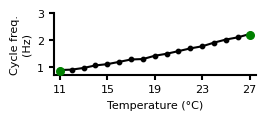

In [211]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2.6, 0.8))
    xaxis = np.arange(11, 28, skip_steps)
    for traces in all_durs_each_set:
        ax.plot(xaxis, 1./traces*1000, 'k')
    for traces in all_durs_each_set:
        ax.scatter(xaxis, 1./traces*1000, s=10, c='k', zorder=1000)

    ax.scatter(11, 1/xo11[0]*1000, s=30, color='green', zorder=10000)
    ax.scatter(27, 1/xo27[0]*1000, s=30, color='green', zorder=10000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([10.5, 27.5])
    ax.set_xticks([11, 15, 19, 23, 27])
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Cycle freq.\n(Hz)")
    ax.set_ylim([0.70, 3])
    plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    plt.show()

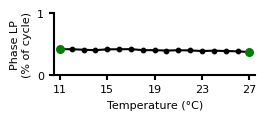

In [212]:
phase_LP = all_stats_each_set[:, :, 7]
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2.6, 0.8))
    xaxis = np.arange(11, 28, skip_steps)
    for traces in phase_LP:
        ax.plot(xaxis, traces, 'k')
    for traces in phase_LP:
        ax.scatter(xaxis, traces, s=10, c='k', zorder=1000)

    ax.scatter(11, xo11[7], s=30, color='green', zorder=1000000)
    ax.scatter(27, xo27[7], s=30, color='green', zorder=1000000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([10.5, 27.5])
    ax.set_xticks([11, 15, 19, 23, 27])
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Phase LP\n(% of cycle)")
    ax.set_ylim([0,1])
    ax.set_yticks([0,1])
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

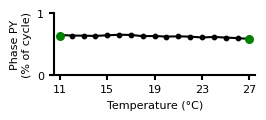

In [213]:
phase_PY = all_stats_each_set[:, :, 8]
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2.6, 0.8))
    xaxis = np.arange(11, 28, skip_steps)
    for traces in phase_PY:
        ax.plot(xaxis, traces, 'k')
    for traces in phase_PY:
        ax.scatter(xaxis, traces, s=10, c='k', zorder=1000)

    ax.scatter(11, xo11[8], s=30, color='green', zorder=1000000)
    ax.scatter(27, xo27[8], s=30, color='green', zorder=1000000)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([10.5, 27.5])
    ax.set_xticks([11, 15, 19, 23, 27])
    ax.set_xlabel("Temperature (°C)")
    ax.set_ylabel("Phase PY\n(% of cycle)")
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 1])
    plt.savefig(PANEL_C3, facecolor='None', transparent=True)
    plt.show()

# Relation between energy efficiency and temperature robustness

### Load samples from 27deg posterior. Samples have been rejected if too far from obs at 11deg and then been simulated at 27deg

In [214]:
all_total_energies_11 = x_11_11_close['energies'].to_numpy()
all_total_energies_27 = x_27_11_close['energies'].to_numpy()
all_total_energies_rejection = x_11_11_rejection_nan['energies'].to_numpy()

In [215]:
summed_energies_total_11 = np.sum(np.asarray(all_total_energies_11), axis=1) / 10 / 1000 # per second, micro-Joule
summed_energies_total_27 = np.sum(np.asarray(all_total_energies_27), axis=1) / 10 / 1000
summed_energies_total_27_rejection = np.sum(np.asarray(all_total_energies_rejection), axis=1) / 10 / 1000

In [216]:
summed_energies_total_11.shape

(35939,)

In [217]:
summed_energies_total_27.shape

(6131,)

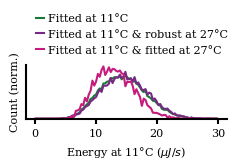

In [218]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(2.6, 0.7))

    hist_vals_11 = ax.hist(summed_energies_total_11, range=(0, 30), bins=100, color='w', density=True)
    hist_vals_27_rob = ax.hist(summed_energies_total_27_rejection, range=(0, 30), bins=100, color='w', density=True)
    hist_vals_27 = ax.hist(summed_energies_total_27, range=(0, 30), bins=100, color='w', density=True)

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
    line27robust = ax.plot(hist_vals_27_rob[1][:-1]+hist_diff/2, hist_vals_27_rob[0], c='#762a83')
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#c51b7d')
    ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
    ax.set_ylabel('Count (norm.)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0, 0.13])
    ax.set_yticks([])

    plt.legend((line11[0], line27robust[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11°C & robust at 27°C', 'Fitted at 11°C & fitted at 27°C'), bbox_to_anchor=(0.0, 1.0, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

    plt.savefig(PANEL_D1, facecolor='None', transparent=True)

In [219]:
# with mpl.rc_context(fname='../../../.matplotlibrc'):
#     fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.9))

#     hist_vals_11 = ax.hist(summed_energies_total_11, range=(0, 30), bins=100, color='w', density=True)
#     hist_vals_27 = ax.hist(summed_energies_total_27, range=(0, 30), bins=100, color='w', density=True)

#     hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
#     line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
#     line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#c51b7d')
#     ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_ylim([0, 0.14])
#     ax.set_yticks([])

#     plt.legend((line11[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11 & 27°C'), bbox_to_anchor=(0.6, 1.1, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

#     plt.savefig(PANEL_D1, facecolor='None', transparent=True)

In [220]:
# with mpl.rc_context(fname='../../../.matplotlibrc'):
#     fig, ax = plt.subplots(1, 1, figsize=(1.6, 0.9))

#     hist_vals_11 = ax.hist(summed_energies_total_11, range=(0, 30), bins=100, color='w', density=True)
#     hist_vals_27 = ax.hist(summed_energies_total_27_rejection, range=(0, 30), bins=100, color='w', density=True)

#     hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
#     line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
#     line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#762a83')
#     ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
#     ax.set_ylabel('Count (norm.)')
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_ylim([0, 0.14])

#     plt.legend((line11[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11°C & \nrobust at 27°C'), bbox_to_anchor=(0.5, 1.1, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

#     plt.savefig(PANEL_D2, facecolor='None', transparent=True)

# Compose figure

In [297]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [387]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "12.5cm",

    Panel(
          SVG(PANEL_exp1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", -2.0*factor_svg, 2.9*factor_svg, **kwargs_text),
        Text("Experimental recording at 11°C", 2.5*factor_svg, 3.0*factor_svg, **kwargs_text8pt),
    ).move(2*factor_svg, -0.3*factor_svg),

    Panel(
          SVG(PANEL_exp2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
        Text("Experimental recording at 27°C", 2.5*factor_svg, 3.0*factor_svg, **kwargs_text8pt),
    ).move(2*factor_svg, 17*factor_svg),
           
    Panel(
          SVG(PANEL_A1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("Posterior 11°C", 8.2*factor_svg, 1.5*factor_svg, **kwargs_text8pt),
          Text("b",-1.0*factor_svg, 1.6*factor_svg, **kwargs_text),
    ).move(40*factor_svg, 1.2*factor_svg),

    Panel(
          SVG(PANEL_A2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("Posterior 11°C & 27°C", 5.3*factor_svg, 1.5*factor_svg, **kwargs_text8pt),
    ).move(72*factor_svg, 1.2*factor_svg),

    Panel(
          SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", -0.5*factor_svg, 0.6*factor_svg, **kwargs_text),
          Text("Posterior sample at 11°C", 5.3*factor_svg, 0.7*factor_svg, **kwargs_text8pt),
    ).move(109*factor_svg, 2.0*factor_svg),

    Panel(
          SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("Posterior sample at 27°C", 5.3*factor_svg, 1.0*factor_svg, **kwargs_text8pt),
    ).move(109*factor_svg, 19*factor_svg),

    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("d", 0.0*factor_svg, 1.1*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 38*factor_svg),

    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(47*factor_svg, 38*factor_svg),

    Panel(
          SVG(PANEL_C3).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(96*factor_svg, 38*factor_svg),
    
    Panel(
          SVG(PANEL_F).scale(svg_scale).move(0*factor_svg,0*factor_svg),
         Text("e", -0.85*factor_svg, 0.5*factor_svg, **kwargs_text),
    ).move(0.85*factor_svg, 62*factor_svg),
    
    Panel(
          SVG(PANEL_G).scale(svg_scale).move(0*factor_svg,0*factor_svg),
         Text("f", 0.0*factor_svg, 1.1*factor_svg, **kwargs_text),
    ).move(45.5*factor_svg, 61.3*factor_svg),

#     Panel(
#           SVG(PANEL_D2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
#         Text("g", 0.5*factor_svg, 2.5*factor_svg, **kwargs_text),
#     ).move(86*factor_svg, 59.83*factor_svg),

    Panel(
          SVG(PANEL_D1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
        Text("g", -0.5*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(100.5*factor_svg, 59.0*factor_svg),

)

!mkdir -p fig
f.save("../fig/fig6.svg")
svg('../fig/fig6.svg')

### Compose supplementary

In [223]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "3.7cm",

    Panel(
          SVG(PANEL_F_supp1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(3*factor_svg, 0*factor_svg),

    Panel(
          SVG(PANEL_F_supp2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(40*factor_svg, 0.5*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig6_supp2.svg")
svg('../fig/fig6_supp2.svg')